In [1]:
import torch, math
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
!pip install torchsummary
from torchsummary import summary
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
!pip install torchsummary
from torchsummary import summary
!pip install einops
from math import ceil
# !pip install nystrom-attention
# !pip install performer_pytorch
!pip install linformer
from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from einops import rearrange, reduce

# helpers
from einops import reduce

transform = transforms.Compose(
        [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def accuracy(output, target, topk=(1,5)):
    """Computes the precision@k for the specified values of k
    prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
    """
    maxk = max(topk)
         # sizefunction: the number of total elements
    batch_size = target.size(0) 
 
         # topk function selects the number of k before output
    _, pred = output.topk(maxk, 1, True, True)
         ##########Do not understand t()k
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))   
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
import math
import torch
from torch import nn
import torch.nn.functional as F

from linformer.reversible import ReversibleSequence, SequentialSequence

def rotate_every_two(x):
    x = rearrange(x, '... (d j) -> ... d j', j = 2)
    x1, x2 = x.unbind(dim = -1)
    x = torch.stack((-x2, x1), dim = -1)
    return rearrange(x, '... d j -> ... (d j)')

def apply_rotary_pos_emb(q, k, sinu_pos):
    sinu_pos = rearrange(sinu_pos, '() n (j d) -> n j d', j = 2)
    sin, cos = sinu_pos.unbind(dim = -2)

    sin, cos = map(lambda t: repeat(t, 'b n -> b (n j)', j = 2), (sin, cos))
    q, k = map(lambda t: (t * cos) + (rotate_every_two(t) * sin), (q, k))
    return q, k

class FixedPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len):
        super().__init__()
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        position = torch.arange(0, max_seq_len, dtype=torch.float)
        sinusoid_inp = torch.einsum("i,j->ij", position, inv_freq)
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        self.register_buffer('emb', emb)

    def forward(self, x):
        return self.emb[None, :x.shape[1], :].to(x)

def exists(val):
    return val is not None

def default(val, default_val):
    return val if val is not None else default_val

def init_(tensor):
    dim = tensor.shape[-1]
    std = 1 / math.sqrt(dim)
    tensor.uniform_(-std, std)
    return tensor

class LinformerSelfAttention(nn.Module):
    def __init__(self, dim, seq_len, k = 256, heads = 8, dim_head = None, one_kv_head = False, share_kv = False, dropout = 0.):
        super().__init__()
        assert (dim % heads) == 0, 'dimension must be divisible by the number of heads'

        self.seq_len = seq_len
        self.k = k

        self.heads = heads

        dim_head = default(dim_head, dim // heads)
        self.dim_head = dim_head

        self.to_q = nn.Linear(dim, dim_head * heads, bias = False)

        kv_dim = dim_head if one_kv_head else (dim_head * heads)
        self.to_k = nn.Linear(dim, kv_dim, bias = False)
        self.proj_k = nn.Parameter(init_(torch.zeros(seq_len, k)))

        self.share_kv = share_kv
        if not share_kv:
            self.to_v = nn.Linear(dim, kv_dim, bias = False)
            self.proj_v = nn.Parameter(init_(torch.zeros(seq_len, k)))

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.Linear(dim_head * heads, dim)

    def forward(self, x, pos_emb = None, context = None, **kwargs):
        b, n, d, d_h, h, k = *x.shape, self.dim_head, self.heads, self.k

        kv_len = n if context is None else context.shape[1]
        assert kv_len == self.seq_len, f'the sequence length of the key / values must be {self.seq_len} - {kv_len} given'

        queries = self.to_q(x)

        proj_seq_len = lambda args: torch.einsum('bnd,nk->bkd', *args)

        kv_input = x if context is None else context

        keys = self.to_k(kv_input)
        values = self.to_v(kv_input) if not self.share_kv else keys

        queries, keys = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (queries, keys))

        if exists(pos_emb): 
            queries, keys = apply_rotary_pos_emb(queries, keys, pos_emb)
            queries, keys = map(lambda t: rearrange(t, 'b h n d -> b n (h d)', h = h), (queries, keys))
        

        kv_projs = (self.proj_k, self.proj_v if not self.share_kv else self.proj_k)

        # project keys and values along the sequence length dimension to k

        keys, values = map(proj_seq_len, zip((keys, values), kv_projs))

        # merge head into batch for queries and key / values

        queries = queries.reshape(b, n, h, -1).transpose(1, 2)

        merge_key_values = lambda t: t.reshape(b, k, -1, d_h).transpose(1, 2).expand(-1, h, -1, -1)
        keys, values = map(merge_key_values, (keys, values))
        
        # attention

        dots = torch.einsum('bhnd,bhkd->bhnk', queries, keys) * (d_h ** -0.5)
        attn = dots.softmax(dim=-1)
        attn = self.dropout(attn)
        out = torch.einsum('bhnk,bhkd->bhnd', attn, values)

        # split heads
        out = out.transpose(1, 2).reshape(b, n, -1)
        return self.to_out(out)

In [3]:
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        k = 64
        seq_len = 1025
        one_kv_head = False #use False for RoPE
        share_kv = True
        reversible = False
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, LinformerSelfAttention(dim, seq_len, k = k, heads = heads, dim_head = dim_head, one_kv_head = one_kv_head, share_kv = share_kv, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x, pos_emb):
        for attn, ff in self.layers:
            x = attn(x, pos_emb = pos_emb) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0., rotary_position_emb = True):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride = 1, padding = 1),
            nn.Conv2d(32, 64, 3, stride = 1, padding = 1),
            nn.Conv2d(64, dim, 3, stride = 1, padding = 1),
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width)
            
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        max_seq_len = 1025
        if rotary_position_emb:
            self.layer_pos_emb = FixedPositionalEmbedding(dim_head, max_seq_len)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
#         x += self.pos_embedding[:, :(n + 1)] #1D learnable PE
        x = self.dropout(x)

        layer_pos_emb = self.layer_pos_emb(x)
        x = self.transformer(x, pos_emb = layer_pos_emb)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [4]:
model = ViT(
    image_size = 32,
    patch_size = 1,
    num_classes = 10,             # number of stages
    dim = 128,  # dimensions at each stage
    depth = 4,              # transformer of depth 4 at each stage
    heads = 4,      # heads at each stage
    mlp_dim = 256,
    dropout = 0.,
    dim_head = 32
)


model.to(device)
print(summary(model, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
            Conv2d-3          [-1, 128, 32, 32]          73,856
         Rearrange-4            [-1, 1024, 128]               0
           Dropout-5            [-1, 1025, 128]               0
FixedPositionalEmbedding-6             [-1, 1025, 32]               0
         LayerNorm-7            [-1, 1025, 128]             256
            Linear-8            [-1, 1025, 128]          16,384
            Linear-9            [-1, 1025, 128]          16,384
          Dropout-10          [-1, 4, 1025, 64]               0
           Linear-11            [-1, 1025, 128]          16,512
LinformerSelfAttention-12            [-1, 1025, 128]               0
          PreNorm-13            [-1, 1025, 128]               0
        LayerNorm-14        

In [5]:
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
top1 = []
top5 = []
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
for epoch in range(40):  # loop over the dataset multiple times
    t0 = time.time()
    epoch_accuracy = 0
    epoch_loss = 0
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        with torch.cuda.amp.autocast():
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(trainloader)
        epoch_loss += loss / len(trainloader)

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    correct = 0
    total = 0
    correct_1=0
    correct_5=0
    c = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
#         outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            res = accuracy(outputs, labels)
            correct_1 += res[0][0].float()
            correct_5 += res[1][0].float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c += 1
        
    print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - Top 1: {correct_1/c} - Top 5: {correct_5/c} - Time: {time.time() - t0}\n")
    top1.append(correct_1/c)
    top5.append(correct_5/c)
    if float(correct_1/c) >= float(max(top1)):
        PATH = 'ViLCNNRoPE.pth'
        torch.save(model.state_dict(), PATH)
        print(1)
print('Finished Training')

Epoch : 1 - loss : 1.6135 - acc: 0.4112 - Top 1: 49.453125 - Top 5: 93.1640625 - Time: 133.58766794204712

1
Epoch : 2 - loss : 1.3192 - acc: 0.5204 - Top 1: 54.404296875 - Top 5: 94.8046875 - Time: 133.83519315719604

1
Epoch : 3 - loss : 1.1732 - acc: 0.5783 - Top 1: 57.5390625 - Top 5: 95.576171875 - Time: 133.75986671447754

1
Epoch : 4 - loss : 1.0655 - acc: 0.6172 - Top 1: 59.70703125 - Top 5: 96.103515625 - Time: 133.9139428138733

1
Epoch : 5 - loss : 0.9645 - acc: 0.6558 - Top 1: 60.95703125 - Top 5: 96.337890625 - Time: 133.80614686012268

1
Epoch : 6 - loss : 0.8673 - acc: 0.6904 - Top 1: 61.806640625 - Top 5: 96.494140625 - Time: 133.80714511871338

1
Epoch : 7 - loss : 0.7745 - acc: 0.7235 - Top 1: 63.14453125 - Top 5: 96.6796875 - Time: 133.76443529129028

1
Epoch : 8 - loss : 0.6833 - acc: 0.7564 - Top 1: 63.271484375 - Top 5: 96.640625 - Time: 133.71886563301086

1
Epoch : 9 - loss : 0.6075 - acc: 0.7840 - Top 1: 63.408203125 - Top 5: 96.81640625 - Time: 133.84882187843

KeyboardInterrupt: 

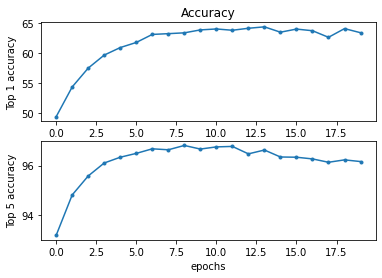

(20,)

In [6]:
plt.subplot(2, 1, 1)
plt.plot(top1, '.-')
plt.title('Accuracy')
plt.ylabel('Top 1 accuracy')

plt.subplot(2, 1, 2)
plt.plot(top5, '.-')
plt.xlabel('epochs')
plt.ylabel('Top 5 accuracy')

plt.show()
